In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, TimeDistributed, RepeatVector
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 불러오기
df = pd.read_csv('../../001_Path_Finder_AStar/012_By_Yeojung/Data/Non-Haar_measure_None_Omega/using/dt_2.6/ByAstar_dt_2.6_1130.csv')

# 데이터프레임의 행을 셔플
df = df.sample(frac=1).reset_index(drop=True)

df = df.dropna(subset=['combination'])
# df = df.drop('Case', axis=1)

df.head(n=10)

,gate length,Theta,Phi,dt,combination,total time,computing time
0,26,2.517721,2.349516,2.6,"[3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, ...",67.6,243.679464
1,4,0.562981,0.856676,2.6,"[4, 4, 1, 1]",10.4,0.802333
2,12,1.276375,5.565582,2.6,"[2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4]",31.2,31.090949
3,10,1.041011,0.927088,2.6,"[1, 1, 3, 3, 2, 2, 4, 4, 1, 1]",26.0,3.057646
4,33,2.950078,3.300094,2.6,"[3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, 1, ...",85.8,136.689723
5,26,2.143937,4.712202,2.6,"[2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, ...",67.6,262.155528
6,9,0.608734,0.810889,2.6,"[1, 1, 3, 3, 2, 4, 1, 1, 3]",23.4,48.627481
7,12,1.098827,5.869375,2.6,"[2, 4, 4, 1, 1, 3, 3, 3, 2, 2, 4, 1]",31.2,636.431581
8,10,0.788725,3.259105,2.6,"[3, 2, 2, 4, 4, 1, 1, 3, 2, 0]",26.0,13.764237
9,27,2.067580,3.273963,2.6,"[3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, ...",70.2,4207.829906


In [5]:
from math import *

def theta_x(theta, phi):
     return sin(theta)*cos(phi)

def theta_y(theta, phi):
     return sin(theta)*sin(phi)

def theta_z(theta):
     return cos(theta)

In [6]:
df['theta_x'] = df.apply(lambda row: theta_x(row['Theta'], row['Phi']), axis=1)
df['theta_y'] = df.apply(lambda row: theta_y(row['Theta'], row['Phi']), axis=1)
df['theta_z'] = df.apply(lambda row: theta_z(row['Theta']), axis=1)

In [7]:

# 데이터셋 분리: train_set 8 : test_set 2
train_df, test_df = train_test_split(df, shuffle=True, test_size=0.2)
# train_set을 다시 8:2로 나눠서 train_set과 validation_set을 만듦
train_df, val_df = train_test_split(train_df, shuffle=True, test_size=0.2)
# random_state=42

# 모든 시퀀스의 길이 중에서 최대 길이를 구하기
all_sequences = [eval(str(seq)) for seq in df['combination'].values]
max_seq_length = max([len(seq) for seq in all_sequences])

# 각 데이터셋에서 theta, phi, sequence 추출하고 reshape 적용
theta_x_train = train_df['theta_x'].values.reshape(-1, 1)
theta_y_train = train_df['theta_y'].values.reshape(-1, 1)
theta_z_train = train_df['theta_z'].values.reshape(-1, 1)
sequence_train = pad_sequences(train_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_x_val = val_df['theta_x'].values.reshape(-1, 1)
theta_y_val = val_df['theta_y'].values.reshape(-1, 1)
theta_z_val = val_df['theta_z'].values.reshape(-1, 1)
sequence_val = pad_sequences(val_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_x_test = test_df['theta_x'].values.reshape(-1, 1)
theta_y_test = test_df['theta_y'].values.reshape(-1, 1)
theta_z_test = test_df['theta_z'].values.reshape(-1, 1)
sequence_test = pad_sequences(test_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')


In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 모델 정의
theta_x_input = Input(shape=(1,), name='theta_x_input')
theta_y_input = Input(shape=(1,), name='theta_y_input')
theta_z_input = Input(shape=(1,), name='theta_z_input')

# theta와 phi를 Concatenate
merged = Concatenate()([theta_x_input, theta_y_input, theta_z_input])

# 시퀀스를 예측하기 위한 GRU 레이어
repeated_vector = RepeatVector(max_seq_length)(merged)  # max_sequence_length는 시퀀스의 최대 길이

rnn_layer = GRU(512, return_sequences=True, name='rnn_layer')(repeated_vector)

output = TimeDistributed(Dense(5, activation='softmax'), name='output_layer')(rnn_layer)

model = Model(inputs=[theta_x_input, theta_y_input, theta_z_input], outputs=output)

# 컴파일 및 훈련
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit([theta_x_train, theta_y_train, theta_z_train], np.expand_dims(sequence_train, -1), 
                    validation_data=([theta_x_val, theta_y_val, theta_z_val], np.expand_dims(sequence_val, -1)), 
                    epochs=500, batch_size=64, callbacks=[early_stopping])

# 검증
loss, accuracy = model.evaluate([theta_x_test, theta_y_test, theta_z_test], np.expand_dims(sequence_test, -1))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


2023-12-29 17:43:05.278635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 17:43:05.361907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 17:43:05.361975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 17:43:05.364887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 17:43:05.364956: I tensorflow/compile

Epoch 1/500


2023-12-29 17:43:07.683150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-29 17:43:07.684575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-29 17:43:07.685656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

315/316 [============================>.] - ETA: 0s - loss: 0.9435 - accuracy: 0.5673

2023-12-29 17:43:12.427467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-29 17:43:12.428964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-29 17:43:12.429846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

316/316 [==============================] - 5s 7ms/step - loss: 0.9428 - accuracy: 0.5675 - val_loss: 0.9029 - val_accuracy: 0.5734
Epoch 2/500
316/316 [==============================] - 2s 6ms/step - loss: 0.8590 - accuracy: 0.5855 - val_loss: 0.7527 - val_accuracy: 0.6725
Epoch 3/500
316/316 [==============================] - 2s 6ms/step - loss: 0.4485 - accuracy: 0.8303 - val_loss: 0.3511 - val_accuracy: 0.8658
Epoch 4/500
316/316 [==============================] - 2s 7ms/step - loss: 0.3310 - accuracy: 0.8754 - val_loss: 0.2887 - val_accuracy: 0.8907
Epoch 5/500
316/316 [==============================] - 2s 6ms/step - loss: 0.3117 - accuracy: 0.8799 - val_loss: 0.2815 - val_accuracy: 0.8922
Epoch 6/500
316/316 [==============================] - 2s 6ms/step - loss: 0.2893 - accuracy: 0.8875 - val_loss: 0.2986 - val_accuracy: 0.8814
Epoch 7/500
316/316 [==============================] - 2s 6ms/step - loss: 0.2828 - accuracy: 0.8890 - val_loss: 0.2631 - val_accuracy: 0.8969
Epoch 8/500

2023-12-29 17:50:35.166896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-29 17:50:35.168196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-29 17:50:35.169461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

198/198 [==============================] - 1s 4ms/step - loss: 0.1598 - accuracy: 0.9304
Test Loss: 0.1598
Test Accuracy: 0.9304


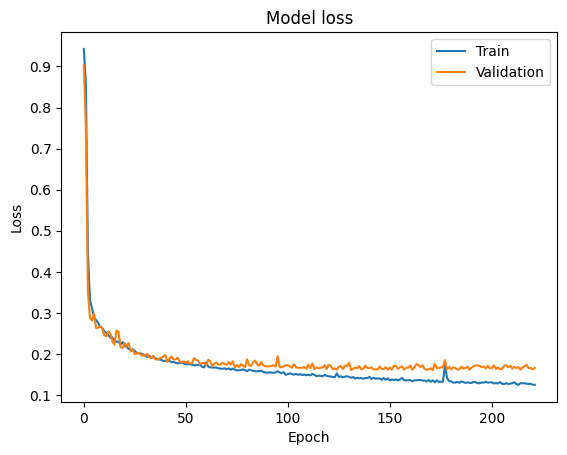

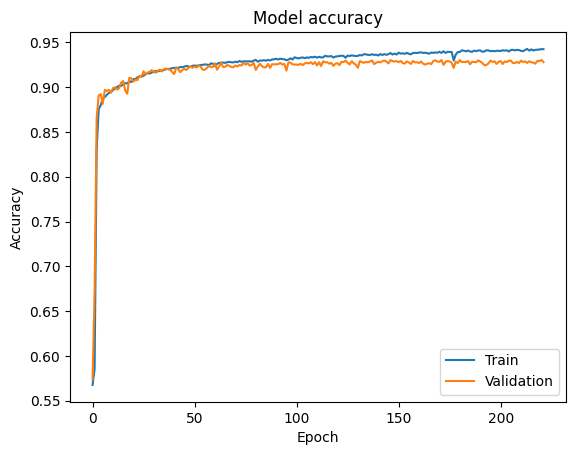

198/198 [==============================] - 1s 6ms/step - loss: 0.1598 - accuracy: 0.9304
Test Accuracy: 93.04
Test Loss: 15.98


In [13]:
def plot_history(history):
         # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        # plt.axis([45, 70, 0, 0.01])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        # plt.axis([45, 60, 0.999, 1.0])
        plt.legend(['Train', 'Validation'], loc='lower right')
        plt.show()

def evaluate(model, theta_x, theta_y, theta_z, sequence):
    loss, acc = model.evaluate({'theta_x_input': theta_x, 'theta_y_input': theta_y, 'theta_z_input': theta_z, 
                                'sequence_input': sequence}, np.expand_dims(sequence, -1))
    print("Test Accuracy: {:.2f}".format(acc*100))
    print("Test Loss: {:.2f}".format(loss*100))

# 결과 그래프 그리기
plot_history(history)

# 모델 성능 평가
evaluate(model, theta_x_test, theta_y_test, theta_z_test, sequence_test)

In [10]:
# 결과를 저장할 디렉토리 생성
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
# 모델 저장
model.save(os.path.join(models_dir, "NVspin_GRU_model_Rho2RealNumber.h5"))

# # 모델 불러오기
# from tensorflow.keras.models import load_model
# loaded_model = load_model("SimpleRNN_model.h5")

In [11]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_x_test), 10)

theta_x_samples = np.array(theta_x_test)[indices]
theta_y_samples = np.array(theta_y_test)[indices]
theta_z_samples = np.array(theta_z_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_x_samples, theta_y_samples, theta_z_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과를 DataFrame으로 변환
df_results = pd.DataFrame({
    'theta_x': theta_x_samples.ravel(),
    'theta_y': theta_y_samples.ravel(),
    'theta_z': theta_z_samples.ravel(),
    'Actual Sequence': [list(seq) for seq in sequence_samples],
    'Predicted Sequence': [list(seq) for seq in predicted_sequences]
})

# 결과를 저장할 디렉토리 생성
results_dir = 'sample_GRU'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# 결과를 CSV 파일로 저장
df_results.to_csv(os.path.join(results_dir, 'GRU_results_Rho2RealNum.csv'), index=False)

print("Results saved to GRU_results_Rho2RealNum.csv")


1/1 [==============================] - 0s 208ms/step
Results saved to GRU_results_Rho2RealNum.csv


2023-12-29 17:50:37.606020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-29 17:50:37.607433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-29 17:50:37.608661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [12]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_x_test), 10)

theta_x_samples = np.array(theta_x_test)[indices]
theta_y_samples = np.array(theta_y_test)[indices]
theta_z_samples = np.array(theta_z_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_x_samples, theta_y_samples, theta_z_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과 출력
for i in range(10):
    print(f"Sample {i + 1}:")
    print("theta_x  :", theta_x_samples[i])
    print("theta_y  :", theta_y_samples[i])
    print("theta_z  :", theta_z_samples[i])
    print("Actual   :", sequence_samples[i])
    print("Predicted:", predicted_sequences[i])
    print("----------")


1/1 [==============================] - 0s 17ms/step
Sample 1:
theta_x  : [-0.04483108]
theta_y  : [-0.09704571]
theta_z  : [0.99426973]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
----------
Sample 2:
theta_x  : [0.0848975]
theta_y  : [0.0459926]
theta_z  : [-0.99532763]
Actual   : [0 0 0 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 2 4]
Predicted: [0 0 0 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 2 4]
----------
Sample 3:
theta_x  : [-0.59012829]
theta_y  : [0.12484877]
theta_z  : [-0.79759726]
Actual   : [0 0 0 0 0 0 0 0 0 0 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2]
Predicted: [0 0 0 0 0 0 0 0 0 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2]
----------
Sample 4:
theta_x  : [-0.40232326]
theta_y  : [0.14081169]
theta_z  : [0.90460381]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 3 3]
Pr

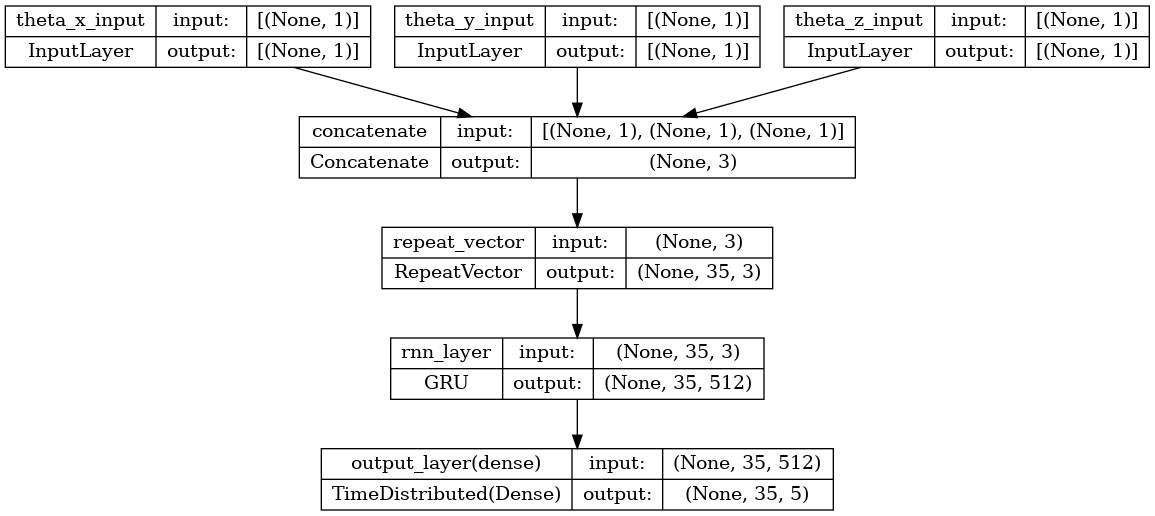

In [14]:
from tensorflow.keras.utils import plot_model

# 모델 구조 시각화
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model, show_shapes=True, show_layer_names=True)